In [9]:
import numpy as np
import os
import re
import plotly.io as pio
import pandas as pd
import random
import matplotlib.pyplot as plt

In [16]:
def get_eval_metric(mtcs, file): # 文件中共有多少次eval，以及最后一次eval的metric值
    i = 0
    metric = '\'acc\': '
    target_str = metric + '\d+.?\d+'
    number_str = '\d+.?\d+'
    for line in open(file,"r"):
        if metric in line:
            word = re.findall(target_str, line)[0]
            mtc = re.findall(number_str, word)[0]
            
            mtcs.append(mtc)
            i = i + 1
    return i, mtcs 

def insert_10(left, right):
    l = [left + 1]
    for i in range(left, right):
        if (i - left -1) % 10 == 0 and i != left + 1:
            l.append(i)
    l.append(right)
    return l

def merge_stack(lists):
    for i in range(len(lists)):
        merged_l = []
        l = lists[i]
        for a in l:
            for b in a:
                merged_l.append(b)
        lists[i] = merged_l
    return lists

def cut(x,y,upper_bound_acc):
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        if isinstance(y, list):
            threshold = y.index(delete_y[0])
        else:
            threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y
            
def sum_duration(depth, width, idx, tmp, time, type = "Dyna-A-Freeze"):
    batch_num = 29
    latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7])
    latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08])
    comm_bert = np.array([0.6, 7.7, 14.8, 21.9, 29.0, 36.0, 43.1, 50.2, 57.3, 64.4, 71.5, 78.6, 109.5]) * 32 / 8 # 这里面没有仅仅freeze embedding的数据
    adapter_para = 0.0125 * width / 8
    comm_adapter =np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4
    
    if type == "BERT" or type == "Freeze":
        latency = latency_tx2_baseline
        comm = comm_bert * 2
    if type == "Quantize" or type == "Q-Freeze": # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 8  # INT4 量化
    if type == "A-Freeze" or type == "Dyna-A-Freeze":
        latency = latency_tx2_cached 
        comm = comm_adapter * 2

    comm_tmp = comm[depth]
    duration = 0
    for i in range(0, idx - tmp):
        comp_tmp = latency[depth] * batch_num
        duration = duration + comp_tmp + comm_tmp
        print(comp_tmp,comm_tmp)
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time


In [11]:
root_path = "/home/cdq/FedNLP"
log_root_path = "experiments/distributed/transformer_exps/run_tc_exps/results/BERT/20news-Trail-0-60"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)

In [ ]:
# depth, width, round, metric
dwrm = [[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], [8, 8, 8, 16, 16, 16, 24, 32, 32, 32, 40, 48, 48, 48, 56, 64, 64, 64, 64, 64], [-1, 79, 88, 180, 272, 364, 453, 539, 625, 711, 794, 875, 956, 1037, 1115, 1191, 1267, 1343, 1393, 1467], [0, '0.4681359532660648', '0.602761550716941', '0.7422995220392989', '0.7559745087626129', '0.7636749867233139', '0.7684545937334042', '0.7729686670207117', '0.7804036112586299', '0.7838555496548062', '0.7892989909718534', '0.7934147636749868', '0.7954062665958577', '0.7966011683483802', '0.7980616038236856', '0.8005841741901222', '0.8029739776951673', '0.8016463090812533', '0.8020446096654275', '0.8031067445565587']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
print(merged_new_dwrm)
# for depth in dwrm:

In [6]:
Origin = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/results/Baseline/20news_uniform_lr=0.1_freeze=_quantize=False_adapter=False_works=5.txt"
Distil = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/results/Baseline/20news_uniform_lr=0.1_freeze=_quantize=True_adapter=False_works=5.txt"
Q_Freeze = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/results/Baseline/20news_uniform_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=True_adapter=False_int4.txt"
Freeze = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/results/Baseline/20news_uniform_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=False_adapter=False.txt"
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*5).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_distil = load_baseline(Distil)
baseline_q_freeze_drm = load_baseline(2, Q_Freeze)
baseline_freeze_drm = load_baseline(2, Freeze)

0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
0.58 0.16
5.22 0.36
5.22 0.36
5.22 0.36
5.22 0.36
5.22 0.36
5.22 0.36
5.22 0.36
5.22 0.36
5.22 0.36
5.22 0.56
5.22 0.56
5.22 0.56
5.22 0.56
5.22 0.56
5.22 0.56
5.22 0.56
5.22 0.56
5.22 0.56
5.22 0.56
5.22 0.56


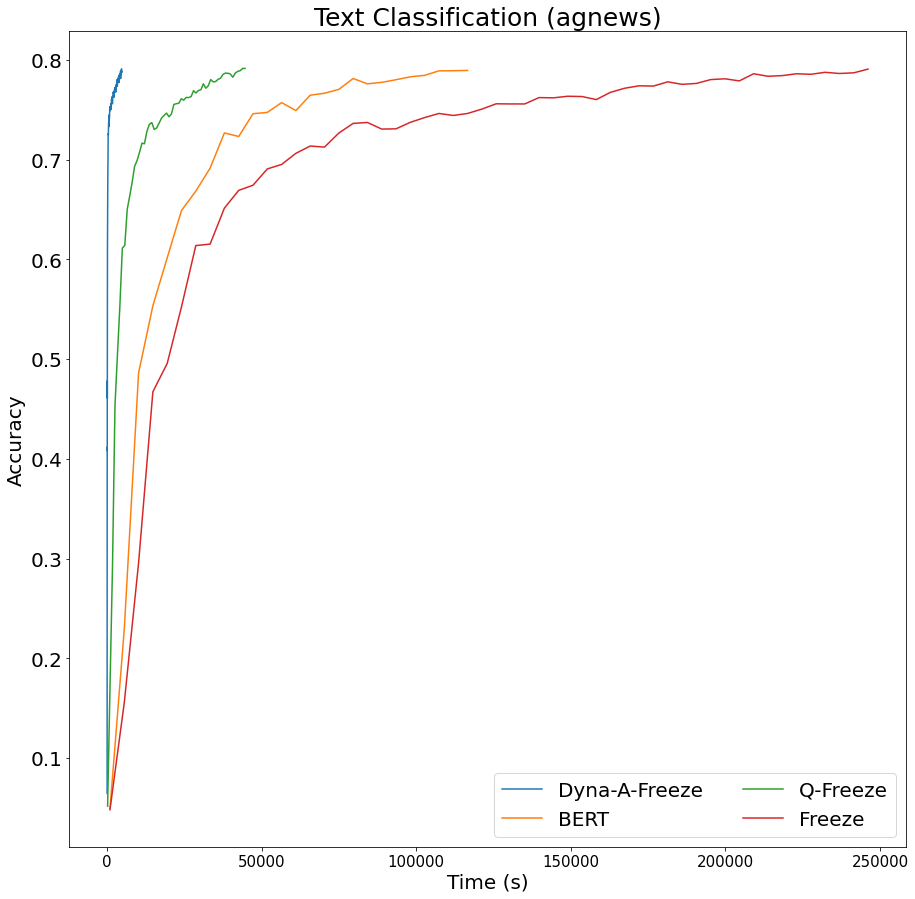

In [17]:
plt.figure(figsize=(15,15))
plt.title("Text Classification (agnews)",fontsize=25)
# 设置刻度字体大小
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
max_acc = 0.8
target_acc = 0.99
max_acc = max_acc * target_acc

time = []


data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Dyna-A-Freeze")
print("Dyna-A-Freeze",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_origin_drm
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "BERT")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "BERT")
print("BERT",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm
y = [float(i) for i in baseline_q_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Q-Freeze")
print("Q-Freeze",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm
y = [float(i) for i in baseline_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Freeze")
print("Freeze",time[-1]/3600)

plt.legend(fontsize=20,ncol = 2)
plt.savefig('./pic/Trial-Ablation.png', bbox_inches="tight")

In [14]:
baseline_freeze_drm[1]

[0,
 80,
 160,
 240,
 320,
 400,
 480,
 560,
 640,
 720,
 800,
 880,
 960,
 1040,
 1120,
 1200,
 1280,
 1360,
 1440,
 1520,
 1600,
 1680,
 1760,
 1840,
 1920,
 2000,
 2080,
 2160,
 2240,
 2320,
 2400,
 2480,
 2560,
 2640,
 2720,
 2800,
 2880,
 2960,
 3040,
 3120,
 3200,
 3280,
 3360,
 3440,
 3520,
 3600,
 3680,
 3760,
 3840,
 3920,
 4000,
 4080,
 4160,
 4240,
 4320,
 4400,
 4480,
 4560,
 4640,
 4720,
 4800,
 4880,
 4960,
 5040,
 5120]